# Non-reversible Parallel Tempering for Uncertainty Approximation

#### Preliminaries

In [1]:
import autograd.numpy as np
""" install autograd: https://github.com/HIPS/autograd """
from autograd import grad
from autograd.numpy import log, sqrt, sin, cos, exp, pi, prod
from autograd.numpy.random import normal, uniform

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import sys
import copy

import numpy as np

#### Set up the random seed

In [2]:
mySeed = 12345
np.random.seed(mySeed)

#### Build a non-convex energy function

In [3]:
def mixture(x):
    energy = 0.2 * (x[0]**2 + x[1]**2) - 2 * (cos(2.0*pi*x[0]) + cos(2.0*pi*x[1]))
    regularizer = ((x[0]**2 + x[1]**2) > 20) * ((x[0]**2 + x[1]**2) - 20)
    return energy + regularizer

def mixture_expand(x, y): return mixture([x, y])
def function_plot(x, y): return np.exp(-mixture([x, y]))

#### Partition the X-Y axis

In [4]:
lower, upper = -2.5, 2.5
axis_x = np.linspace(lower, upper, 1000)
axis_y = np.linspace(lower, upper, 1000)
axis_X, axis_Y = np.meshgrid(axis_x, axis_y)
prob_grid = function_plot(axis_X, axis_Y)

#### Show the ground truth distribution

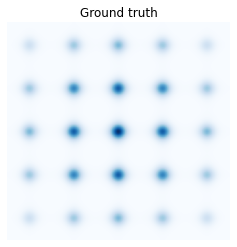

In [5]:
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize=(4, 4))
ax = plt.axes()
sns.heatmap(prob_grid, cmap="Blues", cbar=False, xticklabels=False, yticklabels=False).invert_yaxis()
ax.set_title('Ground truth')
plt.show()

## Build the samplers (including baselines, ensemble SGLD, cycSGLD, and DEO)

In [6]:
class Sampler:
    def __init__(self, f=None, xinit=None, lr=None, T=None, sz=None, correction=None, rate=None, scale=None):
        self.chains = len(xinit)
        self.f = f
        self.lr = lr
        self.T = T
        self.sz = sz
        self.correction = correction

        """ initialization """ 
        self.x = np.array(xinit)
        self.scale = scale
        self.target_rate = rate
        
        """ calculate the round trips """
        self.index_set = np.arange(self.chains)
        self.last_visited = []
        for _ in range(self.chains):
            self.last_visited.append(set())
        self.round_trip = 0
        self.round_trips = [0]
        
        """ Key to generalized DEO """
        self.gates = [1] * self.chains
    
    
    def stochastic_grad(self, beta): return grad(self.f)(beta) + self.scale * normal(size=2)

    def stochastic_f(self, beta): return self.f(beta.tolist()) + self.scale * normal(size=1)
    
    """ Ensemble baseline based on many parallel SGLD chains """
    def sgld_ensemble(self, iters):
        lr, T = 0.003, 1
        self.x = [self.x[i] - lr * self.stochastic_grad(self.x[i]) \
                  + np.sqrt(2 * lr * T) * normal(size=2) for i in range(self.chains)]
    
    """ SGLD with a single long run with cyclical learning rates """
    def cyclic_sgld(self, iters, nepoch):
        total_cycles = 100
        """ number of iterations in each cycle """
        sub_sn = nepoch / total_cycles
        
        for sub_idx in range(self.chains):
            """ use the same of computational iterations """
            sub_iter = iters * self.chains + sub_idx
            self.cur_beta = (sub_iter % sub_sn) * 1.0 / sub_sn
            cur_lr = 0.6 / 2 * (np.cos(np.pi * min(self.cur_beta, 0.95)) + 1)
            if self.cur_beta < 0.95:
                self.x[0] = self.x[0] - cur_lr * self.stochastic_grad(self.x[0])
            else:
                noise = np.sqrt(2 * cur_lr) * normal(size=2)
                self.x[0] = self.x[0] - cur_lr * self.stochastic_grad(self.x[0]) + noise
    
    """ Our proposed algorithm """
    def sgd_step(self, iters, window):
        """ SGLD for exploitation kernels and SGD for exploration kernels """
        noises = [np.sqrt(2 * self.lr[i] * self.T[i]) * normal(size=2) for i in range(self.chains)]
        self.x = [self.x[i] - self.lr[i] * self.stochastic_grad(self.x[i]) + noises[i] for i in range(self.chains)]
        """ Swap indicator for statistics """
        self.swap = [0] * (self.chains - 1)
        
        last_lr = copy.deepcopy(self.lr)
        stepsize = self.sz / (iters**0.8 + 500)
        """ Open the gate """
        if iters % window == 0:
            self.gates = [1] * self.chains
        
        for idx in range(self.chains):
            """ Record historical learning rates for statistics """
            histortical_lrs[idx].append(self.lr[idx])
            
            if idx > 0:
                if self.stochastic_f(self.x[idx]) + self.correction < self.stochastic_f(self.x[idx-1]):
                    self.swap[idx-1] = 1
                if (idx % 2 == ((iters // window) % 2)) and self.gates[idx] == 1 and self.swap[idx-1] == 1:
                    self.index_set[idx-1], self.index_set[idx] = self.index_set[idx], self.index_set[idx-1]
                    self.x[idx-1], self.x[idx] = self.x[idx], self.x[idx-1]
                    """ Close the gate in the current window """
                    self.gates[idx] = 0
                
            """ count the number of round trips: visited two ends """
            self.last_visited[self.index_set[0]].add(0)
            self.last_visited[self.index_set[self.chains-1]].add(self.chains-1)
            
            """ count the number of round trips: returned to the original position """
            if len(self.last_visited[idx]) == 2 and idx == self.index_set[idx]:
                self.last_visited[idx] = set()
                self.round_trip += 1
        
        """ Optimize the learning rates to achieve equi-acceptance rates """
        for idx in range(1, self.chains-1):
            gain1 = max(0, last_lr[idx] - last_lr[idx-1]) * np.exp((self.swap[idx-1] - self.target_rate) * stepsize)
            gain2 = max(0, last_lr[idx+1] - last_lr[idx]) * np.exp((self.swap[idx] - self.target_rate) * stepsize)
            self.lr[idx] = (last_lr[idx-1] + gain1 + last_lr[idx+1] - gain2) / 2
        
        self.round_trips.append(self.round_trip)
        """ Optimize the correction term to maintain the average swapping rates """
        self.correction = self.correction + (np.mean(self.swap) - self.target_rate) * stepsize

#### Total number of running iterations

In [7]:
nepoch = 20000

#### Total number of chains

In [8]:
chains = 16

Standard deviation of gradient / energy estimator

In [9]:
scale = 2

## [1/4] Baselines: ensemble SGLD (16 parallel runs)

In [10]:
xinits = [[uniform(-1, 1), uniform(-1, 1)] for _ in range(chains)]
sampler_ensemble = Sampler(f=mixture, xinit=xinits, scale=scale)

In [11]:
SGLD_ensemble = np.array(sampler_ensemble.x)
warm_up = 100 
for iters in range(int(nepoch+1)):
    sampler_ensemble.sgld_ensemble(iters)
    if iters > warm_up:
        if iters % 10 == 0:
            for cidx in range(chains):
                SGLD_ensemble = np.vstack((SGLD_ensemble, sampler_ensemble.x[cidx]))
        if iters % 4000 == 0:
            print('Iteration {} ({:.0f}% Done)'.format(iters, iters*1.0/nepoch*100))

Iteration 4000 (20% Done)
Iteration 8000 (40% Done)
Iteration 12000 (60% Done)
Iteration 16000 (80% Done)
Iteration 20000 (100% Done)


Text(0.5, 1.0, 'Ensemble SGLD')

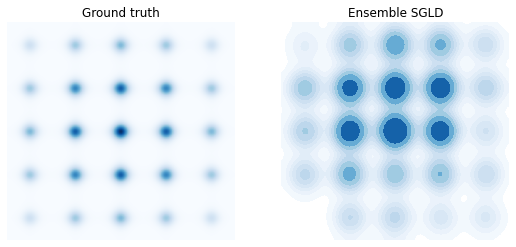

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
sns.heatmap(prob_grid, cmap="Blues", cbar=False, xticklabels=False, yticklabels=False, ax=axs[0]).invert_yaxis()
axs[0].set_title('Ground truth')

sns.kdeplot(SGLD_ensemble[:,0], SGLD_ensemble[:,1],  cmap="Blues", shade=True, thresh=0.05, bw=0.15, ax=axs[1])
axs[1].set_xlim(lower, upper)
axs[1].set_ylim(lower, upper)
axs[1].axis('off')
axs[1].set_title('Ensemble SGLD')

**Comment**: Ensemble SGLD can identify most of the modes, but fails to quantify the uncertainty very well.

## [2/4] Baselines: cyclic SGLD (16 times of running time)

In [13]:
sampler_cyc = Sampler(f=mixture, xinit=xinits, scale=scale)

In [14]:
SGLD_cyc = np.array(sampler_cyc.x)
for iters in range(int(nepoch+1)):
    sampler_cyc.cyclic_sgld(iters, nepoch)
    if iters > warm_up:
        """ Only collect models in exploitation mode """
        if sampler_cyc.cur_beta > 0.95:
            SGLD_cyc = np.vstack((SGLD_cyc, sampler_cyc.x[0]))
        if iters % 4000 == 0:
            print('Iteration {} ({:.0f}% Done)'.format(iters, iters*1.0/nepoch*100))

Iteration 4000 (20% Done)
Iteration 8000 (40% Done)
Iteration 12000 (60% Done)
Iteration 16000 (80% Done)
Iteration 20000 (100% Done)


Text(0.5, 1.0, 'Cyclic SGLD')

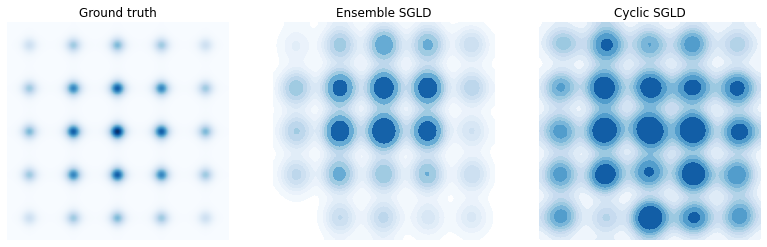

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(13.5, 4))
sns.heatmap(prob_grid, cmap="Blues", cbar=False, xticklabels=False, yticklabels=False, ax=axs[0]).invert_yaxis()
axs[0].set_title('Ground truth')

sns.kdeplot(SGLD_ensemble[:,0], SGLD_ensemble[:,1],  cmap="Blues", shade=True, thresh=0.05, bw=0.15, ax=axs[1])
axs[1].set_xlim(lower, upper)
axs[1].set_ylim(lower, upper)
axs[1].axis('off')
axs[1].set_title('Ensemble SGLD')

sns.kdeplot(SGLD_cyc[:,0], SGLD_cyc[:,1],  cmap="Blues", shade=True, thresh=0.05, bw=0.15, ax=axs[2])
axs[2].set_xlim(lower, upper)
axs[2].set_ylim(lower, upper)
axs[2].axis('off')
axs[2].set_title('Cyclic SGLD')

**Comment**: Cyclic SGLD seems to have a good exploration, but the uncertainty estimate is still not good enough.

## [3/4] Baselines: Run PT via the naive deterministic even-odd (DEO) scheme (DEO-SGD)

#### The default DEO is equivalent to setting a window of size 1

In [16]:
window = 1

### Set up the hyperparameters

#### Fix the lowest & highest learning rates, target swap rate

In [17]:
lr_low = 0.003 # The lowest learning rate is the same as that in ensemble SGLD
lr_high = 0.6  # The highest learning rate is the same as the highest exploration learning rate in cycSGLD
target_rate = 0.4

#### Other inputs

Geometrically initialize learning rates for other chains

In [18]:
ratio = (lr_high / lr_low) ** (1. / (chains-1 + 1e-10))
lrs = [round(lr_low * ratio**power, 3) for power in range(chains)]

Initialize the temperature, which is 1 for SGLD and 0 for exploration kernels via SGD

In [19]:
T = [1] + [0] * (chains - 1)

Hyperparameter for step size of stochastic approximation

In [20]:
sz = 50

In [21]:
xinits = [[uniform(-1, 1), uniform(-1, 1)] for _ in range(chains)]
histortical_lrs = [[] for _ in range(chains)]
sampler_ori = Sampler(f=mixture, xinit=xinits, lr=lrs, T=T, sz=sz, correction=scale**2, rate=target_rate, scale=scale)

In [22]:
NRPT = np.array(sampler_ori.x)
chain_idx_seq, swap_rec = [], []

warm_up = 100 
for iters in range(int(nepoch+1)):
    sampler_ori.sgd_step(iters, window)
    if iters > warm_up:
        """ To study the dynamics of index process """
        chain_idx_seq.append(sampler_ori.index_set.tolist())
        swap_rec.append(sampler_ori.swap)
        if iters % 10 == 0:
            """ Only collect models from the target chain """
            NRPT = np.vstack((NRPT, sampler_ori.x[0]))
            if iters in [200, 500, 1000, 5000, 20000]:
                print('Iteration {}'.format(iters))
                for cidx in range(chains-1):
                    print('Chain {} (lr={:.1e}) with chain {} (lr={:.1e}) window {} trips {} correction {:.1f} swap rate {:.1f}% target rate {:.1f}%'.format(\
                     cidx, sampler_ori.lr[cidx], cidx+1, sampler_ori.lr[cidx+1], window, sampler_ori.round_trip, sampler_ori.correction, \
                         100*np.mean(swap_rec, 0)[cidx], 100*sampler_ori.target_rate))

Iteration 200
Chain 0 (lr=3.0e-03) with chain 1 (lr=6.0e-03) window 1 trips 0 correction 1.4 swap rate 49.0% target rate 40.0%
Chain 1 (lr=6.0e-03) with chain 2 (lr=8.6e-03) window 1 trips 0 correction 1.4 swap rate 39.0% target rate 40.0%
Chain 2 (lr=8.6e-03) with chain 3 (lr=1.2e-02) window 1 trips 0 correction 1.4 swap rate 31.0% target rate 40.0%
Chain 3 (lr=1.2e-02) with chain 4 (lr=1.7e-02) window 1 trips 0 correction 1.4 swap rate 23.0% target rate 40.0%
Chain 4 (lr=1.7e-02) with chain 5 (lr=2.5e-02) window 1 trips 0 correction 1.4 swap rate 24.0% target rate 40.0%
Chain 5 (lr=2.5e-02) with chain 6 (lr=3.0e-02) window 1 trips 0 correction 1.4 swap rate 14.0% target rate 40.0%
Chain 6 (lr=3.0e-02) with chain 7 (lr=3.9e-02) window 1 trips 0 correction 1.4 swap rate 22.0% target rate 40.0%
Chain 7 (lr=3.9e-02) with chain 8 (lr=4.8e-02) window 1 trips 0 correction 1.4 swap rate 23.0% target rate 40.0%
Chain 8 (lr=4.8e-02) with chain 9 (lr=6.7e-02) window 1 trips 0 correction 1.4 swa

Chain 14 (lr=5.2e-01) with chain 15 (lr=6.0e-01) window 1 trips 348 correction 0.5 swap rate 38.7% target rate 40.0%


#### Draw of density for the naive DEO scheme

Text(0.5, 1.0, 'DEO-SGD')

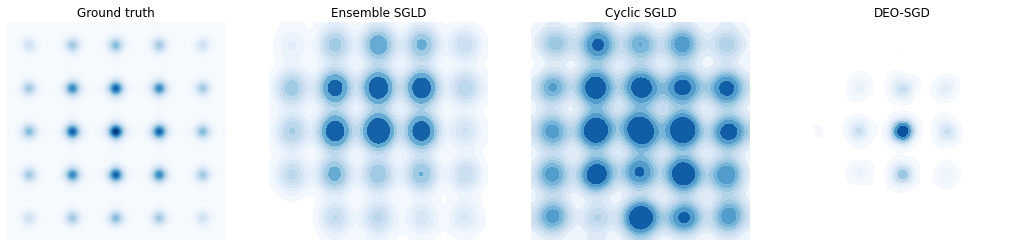

In [23]:
fig, axs = plt.subplots(1, 4, figsize=(18, 4))
sns.heatmap(prob_grid, cmap="Blues", cbar=False, xticklabels=False, yticklabels=False, ax=axs[0]).invert_yaxis()
axs[0].set_title('Ground truth')

sns.kdeplot(SGLD_ensemble[:,0], SGLD_ensemble[:,1],  cmap="Blues", shade=True, thresh=0.05, bw=0.15, ax=axs[1])
axs[1].set_xlim(lower, upper)
axs[1].set_ylim(lower, upper)
axs[1].axis('off')
axs[1].set_title('Ensemble SGLD')

sns.kdeplot(SGLD_cyc[:,0], SGLD_cyc[:,1],  cmap="Blues", shade=True, thresh=0.05, bw=0.15, ax=axs[2])
axs[2].set_xlim(lower, upper)
axs[2].set_ylim(lower, upper)
axs[2].axis('off')
axs[2].set_title('Cyclic SGLD')

sns.kdeplot(NRPT[:,0], NRPT[:,1],  cmap="Blues", shade=True, thresh=0.05, bw=0.15, ax=axs[3])
axs[3].set_xlim(lower, upper)
axs[3].set_ylim(lower, upper)
axs[3].axis('off')
axs[3].set_title('DEO-SGD')

Comment: from the rightmost figure, we see parallel tempering has a **mediocre performance given high round trip costs.**

#### Study the index process

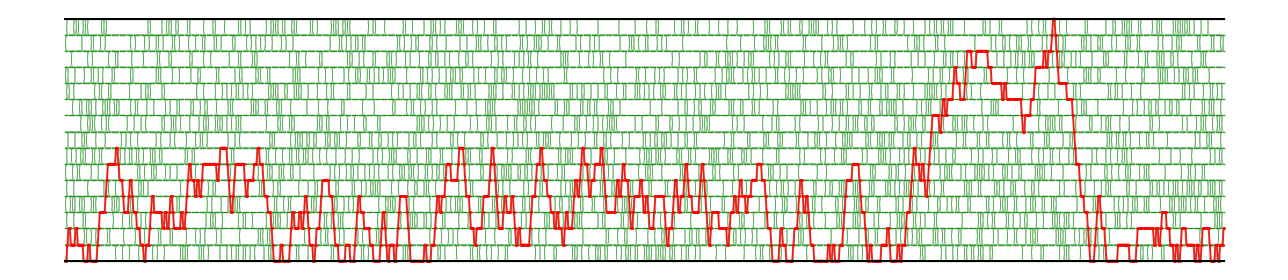

In [24]:
chain_position = [[] for _ in range(chains)]
for item in chain_idx_seq:
    for chain_idx in range(chains):
        chain_position[chain_idx].append(item.index(chain_idx))

iters = np.array(range(len(chain_idx_seq)))
""" For visualization, we only look at iterations from 9k to 10k """
xrange = range(10000, 11000)
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

fig = plt.figure(figsize=(18, 4))
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

for idx in range(chains):
    plt.plot(iters[xrange], np.array(chain_position[idx])[xrange], marker='o', color='green', markersize=0.5, linewidth=0.5, alpha=0.8)

""" find the index with lowest temperature and plot a single pass """
for idx in range(chains):
    if chain_position[idx][xrange[0]] == 0:
        break
plt.plot(iters[xrange], np.array(chain_position[idx])[xrange], marker='o', markersize=2, color='red', linewidth=2, alpha=0.8)

""" plot boundaries """
plt.plot(iters[xrange], [0] * len(xrange), color='black', linewidth=2, alpha=1)
plt.plot(iters[xrange], [chains-1] * len(xrange), color='black', linewidth=2, alpha=1)
plt.xticks([])
plt.yticks([])
plt.tight_layout()

plt.rcParams.update({'font.size': 28})
plt.show()

Comment: The above index process **takes a long time to finish a single round trip** with the naive DEO scheme.

## [4/4] Run PT via the generalized DEO with the optimal window size (DEO$_{\star}$-SGD)

According to our theory, the optimal window size follows that

In [25]:
window = int(np.ceil((np.log(chains) + np.log(np.log(chains))) / -np.log(1-target_rate)))
print('The theoretical optimal window size is {}'.format(window))

The theoretical optimal window size is 8


In [26]:
xinits = [[uniform(-1, 1), uniform(-1, 1)] for _ in range(chains)]
histortical_lrs = [[] for _ in range(chains)]
histortical_acceptance = []
sampler_opt = Sampler(f=mixture, xinit=xinits, lr=lrs, T=T, sz=sz, correction=scale**2, rate=target_rate, scale=scale)

Run the same algorithm again

In [27]:
NRPT_optimal = np.array(sampler_opt.x)
chain_idx_seq_optimal, swap_rec = [], []

warm_up = 100 
for iters in range(int(nepoch+1)):
    sampler_opt.sgd_step(iters, window)
    if iters > warm_up:
        """ To study the dynamics of index process """
        chain_idx_seq_optimal.append(sampler_opt.index_set.tolist())
        swap_rec.append(sampler_opt.swap)
        """ Analyze the acceptance rates """
        histortical_acceptance.append(np.mean(swap_rec, 0))
        if iters % 10 == 0:
            """ Only collect models from the target chain """
            NRPT_optimal = np.vstack((NRPT_optimal, sampler_opt.x[0]))
            if iters in [200, 500, 1000, 5000, 20000]:
                print('Iteration {}'.format(iters))
                for cidx in range(chains-1):
                    print('Chain {} (lr={:.1e}) with chain {} (lr={:.1e}) window {} trips {} correction {:.1f} swap rate {:.1f}% target rate {:.1f}%'.format(\
                     cidx, sampler_opt.lr[cidx], cidx+1, sampler_opt.lr[cidx+1], window, sampler_opt.round_trip, sampler_opt.correction, \
                         100*np.mean(swap_rec, 0)[cidx], 100*sampler_opt.target_rate))

Iteration 200
Chain 0 (lr=3.0e-03) with chain 1 (lr=2.4e-02) window 8 trips 0 correction 1.4 swap rate 39.0% target rate 40.0%
Chain 1 (lr=2.4e-02) with chain 2 (lr=2.7e-02) window 8 trips 0 correction 1.4 swap rate 30.0% target rate 40.0%
Chain 2 (lr=2.7e-02) with chain 3 (lr=3.1e-02) window 8 trips 0 correction 1.4 swap rate 29.0% target rate 40.0%
Chain 3 (lr=3.1e-02) with chain 4 (lr=3.4e-02) window 8 trips 0 correction 1.4 swap rate 27.0% target rate 40.0%
Chain 4 (lr=3.4e-02) with chain 5 (lr=3.7e-02) window 8 trips 0 correction 1.4 swap rate 24.0% target rate 40.0%
Chain 5 (lr=3.7e-02) with chain 6 (lr=4.1e-02) window 8 trips 0 correction 1.4 swap rate 25.0% target rate 40.0%
Chain 6 (lr=4.1e-02) with chain 7 (lr=4.5e-02) window 8 trips 0 correction 1.4 swap rate 31.0% target rate 40.0%
Chain 7 (lr=4.5e-02) with chain 8 (lr=4.6e-02) window 8 trips 0 correction 1.4 swap rate 34.0% target rate 40.0%
Chain 8 (lr=4.6e-02) with chain 9 (lr=1.3e-01) window 8 trips 0 correction 1.4 swa

Chain 13 (lr=4.5e-01) with chain 14 (lr=5.2e-01) window 8 trips 875 correction 0.4 swap rate 39.2% target rate 40.0%
Chain 14 (lr=5.2e-01) with chain 15 (lr=6.0e-01) window 8 trips 875 correction 0.4 swap rate 39.0% target rate 40.0%


#### Draw of density for the DEO$_{\star}$ scheme

Text(0.5, 1.0, 'DEO$_{\\star}$-SGD (window=8)')

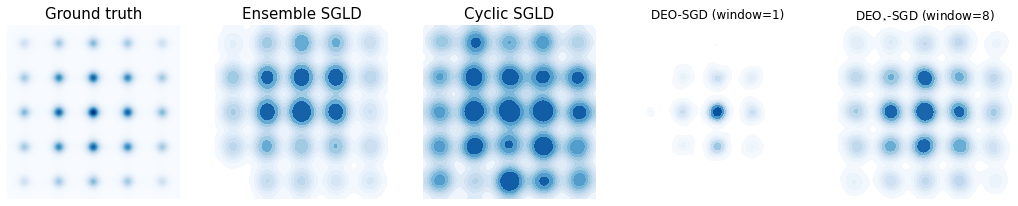

In [28]:
fig, axs = plt.subplots(1, 5, figsize=(18, 3.2))
sns.heatmap(prob_grid, cmap="Blues", cbar=False, xticklabels=False, yticklabels=False, ax=axs[0]).invert_yaxis()
axs[0].set_title('Ground truth', fontsize=15)

sns.kdeplot(SGLD_ensemble[:,0], SGLD_ensemble[:,1],  cmap="Blues", shade=True, thresh=0.05, bw=0.15, ax=axs[1])
axs[1].set_xlim(lower, upper)
axs[1].set_ylim(lower, upper)
axs[1].axis('off')
axs[1].set_title('Ensemble SGLD', fontsize=15)

sns.kdeplot(SGLD_cyc[:,0], SGLD_cyc[:,1],  cmap="Blues", shade=True, thresh=0.05, bw=0.15, ax=axs[2])
axs[2].set_xlim(lower, upper)
axs[2].set_ylim(lower, upper)
axs[2].axis('off')
axs[2].set_title('Cyclic SGLD', fontsize=15)

sns.kdeplot(NRPT[:,0], NRPT[:,1],  cmap="Blues", shade=True, thresh=0.05, bw=0.15, ax=axs[3])
axs[3].set_xlim(lower, upper)
axs[3].set_ylim(lower, upper)
axs[3].axis('off')
axs[3].set_title('DEO-SGD (window=1)', fontsize=12)

sns.kdeplot(NRPT_optimal[:,0], NRPT_optimal[:,1],  cmap="Blues", shade=True, thresh=0.05, bw=0.15, ax=axs[4])
axs[4].set_xlim(lower, upper)
axs[4].set_ylim(lower, upper)
axs[4].axis('off')
axs[4].set_title('DEO$_{\star}$-SGD (window=8)', fontsize=12)

Comment: given the same training cost, non-reversible PT with **the optimal window size approximates the ground truth density the best.**

#### Study the index process

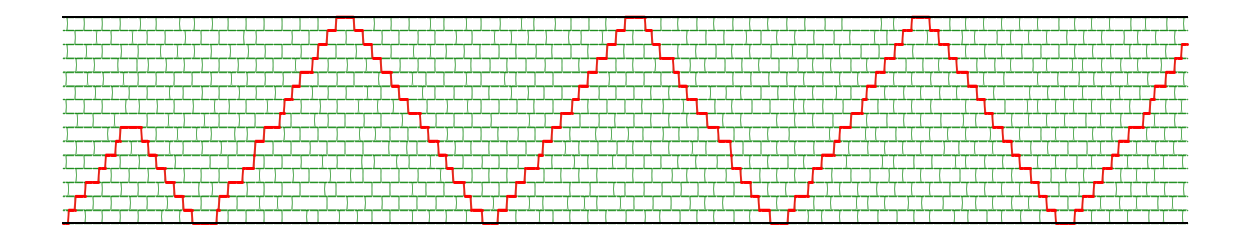

In [29]:
chain_position = [[] for _ in range(chains)]
for item in chain_idx_seq_optimal:
    for chain_idx in range(chains):
        chain_position[chain_idx].append(item.index(chain_idx))

iters = np.array(range(len(chain_idx_seq_optimal)))
""" For visualization, we only look at iterations from 9k to 10k """
xrange = range(10000, 11000)
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

fig = plt.figure(figsize=(18, 4))
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

for idx in range(chains):
    plt.plot(iters[xrange], np.array(chain_position[idx])[xrange], marker='o', color='green', markersize=0.5, linewidth=0.5, alpha=0.8)

""" find the index with lowest temperature and plot a single pass """
for idx in range(chains):
    if chain_position[idx][xrange[0]] == 0:
        break
plt.plot(iters[xrange], np.array(chain_position[idx])[xrange], marker='o', markersize=2, color='red', linewidth=2, alpha=0.8)

""" plot boundaries """
plt.plot(iters[xrange], [0] * len(xrange), color='black', linewidth=2, alpha=1)
plt.plot(iters[xrange], [chains-1] * len(xrange), color='black', linewidth=2, alpha=1)
plt.xticks([])
plt.yticks([])
plt.tight_layout()

plt.rcParams.update({'font.size': 28})
plt.show()

**Comment**: compared with the previous figure, we see less swaps in a window, but the round trips become more **deterministic and regular**.

#### Comparison of round trips

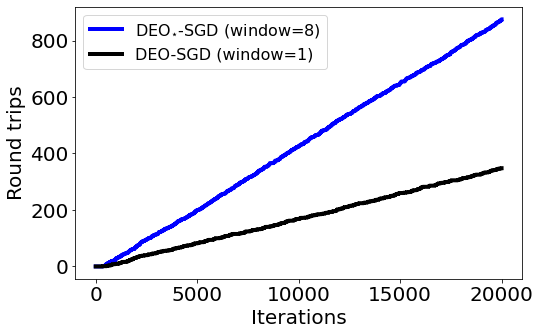

In [32]:
fig = plt.figure(figsize=(8, 5))
plt.plot(range(len(sampler_opt.round_trips)), sampler_opt.round_trips, linewidth=4, color='blue', label=r'DEO$_{\star}$-SGD (window=8)')
plt.plot(range(len(sampler_ori.round_trips)), sampler_ori.round_trips, linewidth=4, color='black', label='DEO-SGD (window=1)')
plt.ylabel('Round trips')
plt.xlabel('Iterations')
plt.legend(loc="upper left", fontsize=16)
plt.show()

#### Convergence of acceptance rates

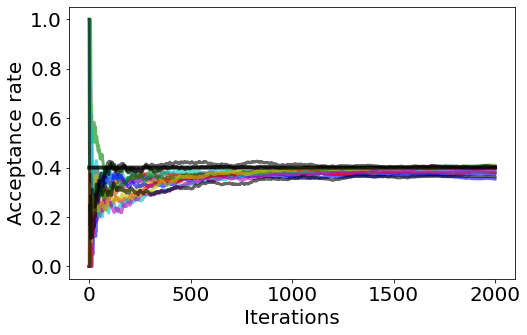

In [31]:
fig = plt.figure(figsize=(8, 5))
histortical_acceptance = np.array(histortical_acceptance)
plt.rcParams.update({'font.size': 20})
maxLen = 2000
for idx in range(chains-2, 0, -1):
    plt.plot(range(len(histortical_acceptance[:maxLen, 0])), (histortical_acceptance[:maxLen, idx]), linewidth=3, alpha=0.6, label = "C"+str(idx))
plt.plot(range(len(histortical_acceptance[:maxLen, 0])), (histortical_acceptance[:maxLen, 0]), linewidth=3, alpha=0.6, color="black", label ="C0")
plt.plot(range(len(histortical_acceptance[:maxLen, 0])), [0.4] * maxLen, linewidth=4, alpha=0.8, color='black')
plt.ylabel('Acceptance rate')
plt.xlabel('Iterations')
plt.show()